In [3]:
import copy
import torch
import tqdm
import numpy as np 
import gymnasium as gym
from gym.utils.env_checker import check_env
from typing import (
    Tuple,
    Callable,
    List,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3

2023-05-08 22:16:26.456312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 22:16:27.251206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [4]:
N = 100 # number of datapoints 
x = np.linspace(-2, 2, N) # sequences from -3 to 3 with N values

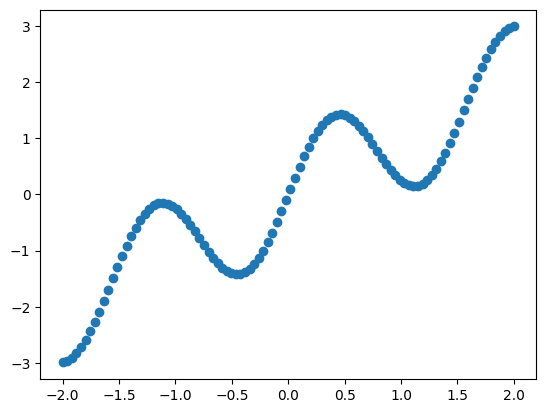

In [5]:
sine_wave = x + np.sin(4*x)
plt.plot(x, sine_wave, 'o');

In [6]:
# y
sine_wave

array([-2.98935825, -2.95947432, -2.90353058, -2.82193204, -2.71575235,
       -2.58670583, -2.43710276, -2.26978919, -2.08807276, -1.89563649,
       -1.69644281, -1.49463023, -1.29440554, -1.09993415, -0.91523152,
       -0.74405849, -0.58982329, -0.4554927 , -0.34351473, -0.25575481,
       -0.19344717, -0.15716269, -0.14679399, -0.16155828, -0.20001769,
       -0.2601168 , -0.33923622, -0.4342608 , -0.54166086, -0.6575842 ,
       -0.77795645, -0.89858731, -1.01527972, -1.12393929, -1.22068097,
       -1.30193034, -1.36451675, -1.40575595, -1.42352009, -1.41629312,
       -1.38321035, -1.32408098, -1.23939303, -1.13030068, -0.99859414,
       -0.84665305, -0.67738437, -0.49414671, -0.30066274, -0.10092218,
        0.10092218,  0.30066274,  0.49414671,  0.67738437,  0.84665305,
        0.99859414,  1.13030068,  1.23939303,  1.32408098,  1.38321035,
        1.41629312,  1.42352009,  1.40575595,  1.36451675,  1.30193034,
        1.22068097,  1.12393929,  1.01527972,  0.89858731,  0.77

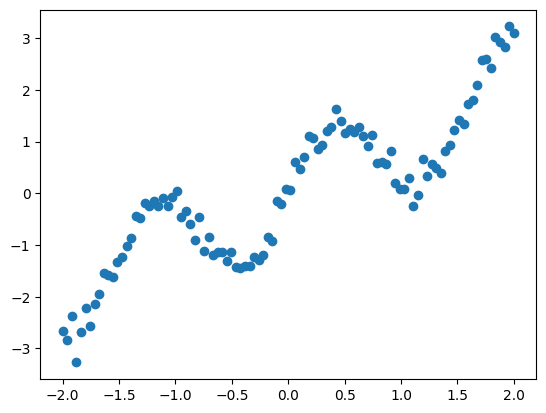

In [7]:
noisy_sine_wave = x + np.sin(4*x) + np.random.normal(0,0.2, 100)
plt.plot(x, noisy_sine_wave, 'o');

In [8]:
# neural network regression
# this has the same architecture for every hidden layer by design
model = torch.nn.Sequential(
    torch.nn.Linear(1, 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24), # hidden layer 1
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24), # hidden layer 2
    torch.nn.ReLU(),
    torch.nn.Linear(24, 1)
)
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

In [23]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def train_regression_model(X_train, y_train, X_test, y_test, n_epochs=100, batch_size=1):
    batch_start = torch.arange(0, len(X_train), batch_size)
    best_mse = np.inf
    best_weights = None
    loss_history = []
    prediction_history = []
    
    ##############
    # 100 epochs #
    ##############
    for epoch in range(n_epochs):
        # train model on batches (which here is just a singular value)
        model.train()
        ################
        # 1000 samples #
        ################
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # update weights via backprop
                opt.zero_grad()
                loss.backward()
                opt.step()

                # print
                bar.set_postfix(mse=float(loss))

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        loss_history.append(mse)
        prediction_history.append(y_pred)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
    
    return prediction_history, loss_history, best_mse, best_weights


In [24]:
x_for_split = x.reshape((N,1))
X_train, y_train, X_test, y_test = split_data(x_for_split, sine_wave)
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([70, 1])
torch.Size([70, 1])
torch.Size([30, 1])
torch.Size([30, 1])


In [25]:
# each x is a single floating point value (think of it as a spot on the number line)
X_train[0]

tensor([-1.7172])

In [26]:
X_train

tensor([[-1.7172],
        [-1.9596],
        [ 0.7879],
        [-1.4343],
        [ 1.9192],
        [-0.7879],
        [-0.6263],
        [-0.0202],
        [ 1.3535],
        [-1.6364],
        [ 0.1010],
        [ 1.8384],
        [ 1.7980],
        [ 0.4646],
        [ 0.7475],
        [ 0.9091],
        [ 1.5960],
        [-0.8283],
        [ 1.7172],
        [-0.9899],
        [ 0.6263],
        [-0.1818],
        [ 1.3939],
        [-1.8788],
        [ 1.2323],
        [ 1.4343],
        [ 2.0000],
        [ 1.1111],
        [-0.0606],
        [ 1.2727],
        [ 0.2222],
        [-0.4242],
        [-1.2727],
        [ 1.5152],
        [-0.6667],
        [-0.7475],
        [-0.2626],
        [ 1.0707],
        [ 1.3131],
        [-1.3939],
        [ 0.5455],
        [-1.1111],
        [ 0.3434],
        [ 0.8283],
        [-1.0303],
        [-0.3838],
        [-1.3131],
        [-0.4646],
        [-1.5556],
        [ 1.1515],
        [ 0.0606],
        [-1.9192],
        [-1.

In [27]:
prediction_history, loss_history, best_mse, best_weights = train_regression_model(X_train, y_train, X_test, y_test, n_epochs=1000, batch_size=1)

In [37]:
len(loss_history)

1000

In [34]:
# list of length n with tensor([30,1]), where n is the number of epochs we ran
prediction_history[0].shape

torch.Size([30, 1])

In [ ]:
# visualize predicted values overlaid with the ground truth values
plt.plot(X_test, prediction_history)
plt.plot(X_test, y_test)

MSE: 0.01
RMSE: 0.09


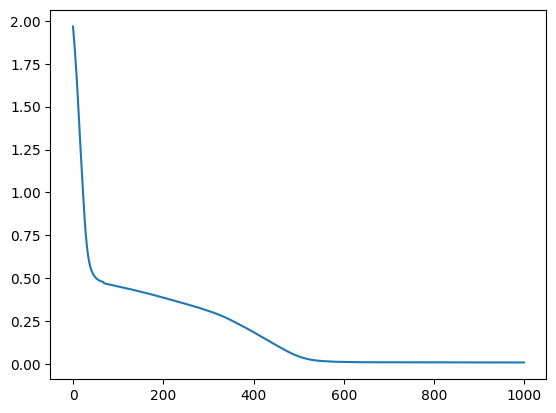

In [ ]:
# visualize the mean squared error (mse)
# non-noisy sine wave
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(loss_history)
plt.show()

In [214]:
nhistory, nbest_mse, nbest_weights = train_regression_model(noisy_X_train, 
                                                         noisy_y_train, 
                                                         noisy_X_test, 
                                                         noisy_y_test,
                                                         n_epochs=1000, 
                                                         batch_size=1)

MSE: 0.05
RMSE: 0.23


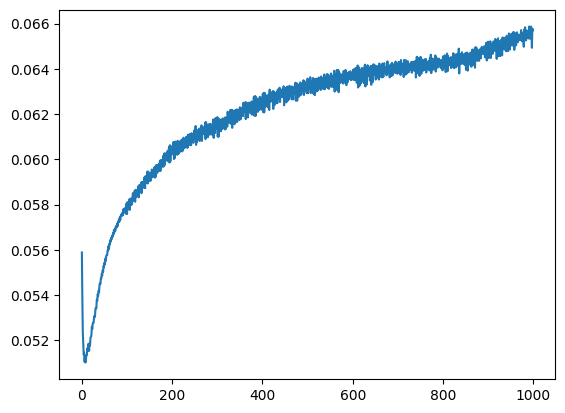

In [229]:
# noisy sine wave
print("MSE: %.2f" % nbest_mse)
print("RMSE: %.2f" % np.sqrt(nbest_mse))
plt.plot(nhistory)
plt.show()

In [249]:
# Create custom env, where each env is where a 'target' model
#   is built for a task. 
# Create agent, where the agent is the meta-learning policy
#   selecting which next layer if any to compose with existing
#   layers.

In [ ]:
DEFAULT_NUM_LAYERS=100
DEFAULT_NUM_NODES=128
DEFAULT_SEED=12
DEFAULT_LOSS_FN=torch.nn.MSELoss()

In [232]:
class LayerPool:
    def __init__(self, 
                 num_layers: int=DEFAULT_NUM_LAYERS, 
                 num_nodes_per_layer: int=DEFAULT_NUM_NODES) -> List[np.ndarray]:
        self.num_layers = num_layers
        self.num_nodes_per_layer = num_nodes_per_layer
        # pre-initialize all layers in dict as 'layer_id' : layer, with xavier uniform
        self.layers = { 
                       f"layer_id_{0}".format(i) : torch.nn.Linear(in_features=num_nodes_per_layer,
                                                                   out_features=num_nodes_per_layer) 
                       for i in num_layers
        }
        [torch.nn.init.xavier_uniform(layer.weight) for _, layer in self.layers.items()]
    
    def update_layer(self, 
                     layer_id: str, 
                     layer: torch.nn.Linear) -> None:
        # called by agent after gradient update is made to layer
        self.layers[layer_id] = layer

    def get_layer(self) -> torch.nn.Linear:
        # called by target model to get the next layer for architecture
        # current design is to choose next layer randomly
        return self.layers[np.random.choice(self.num_layers, 1)]

In [245]:
class Target(gym.Env):
    '''
    Contains the states and the rewards for those states. In this context,
    this is where the 'target' model for the task is constructed. If mode is
    set to 'train' then some preset # of layers is used to 
    
    step() returns the next state (the next layer) and reward (the negative loss)
    reset() returns an initial state and the info dict
    '''
    # input - (2,) which is the coordiantes for point on a sine wave
    # output - (2,) which is the proposed coordinate on a curve????
    def __init__(self, 
                 X: np.ndarray,
                 y: np.ndarray,
                 layer_pool: LayerPool,
                 num_layers: int=DEFAULT_NUM_LAYERS,
                 num_nodes_per_layer: int=DEFAULT_NUM_NODES,
                 loss_fn: Callable=DEFAULT_LOSS_FN):
        super(Target, self).__init__()
        # observation is the output of the layer, in this case a linear or dense layer
        self.observation_space = gym.spaces.Box(low=float('inf'), high=float('-inf'), shape=(num_nodes_per_layer,))
        # action is vector of probabilities corresponding to which layer
        self.action_space = gym.spaces.Box(low=0., high=1., shape=(num_layers+1,)) # +1 for the 'no layer' option
        # state is the current output
        self.state = self.reset() # should this include the loss of the model too?
        self.loss_fn = loss_fn

        # it might not make sense to store the layers in a list like this
        # probably need to expand the held parameters - so to append the state dict
        # self.layers = []
        self.layer_pool = layer_pool

    def reset(self, seed=DEFAULT_SEED) -> Tuple:
        ## Returns initial state (as the same type 'obsevation_space' is) and any 
        ## additional info (as a dict, the same as returned by step).
        super().reset(seed=seed)
        _initial_x = 1 # random 2d array
        random_nn_layer = self.layer_pool[np.random.choice(self.num_layers, 1)] # index to grab random layer from pool
        initial_state = torch.nn.ReLU(random_nn_layer(_initial_x))
        return initial_state, {}
    
    def forward(self, data):
        #TODO(ms)
        # includes the layers
        # how to accomodate the data sample in this class?
        pass

    def step(self, action):
        state_prime = self.forward(action)
        # reward = ...method(state_prime)
        done = truncated = False
        y = ...
        y_hat = ...
        reward = self.loss_fn(y, y_hat)
        return (
            state_prime,
            reward, 
            done, 
            truncated, 
            {}
        )

    def close(self):
        pass

In [250]:
env = TargetModel()
check_env(env)

AttributeError: 'TargetModel' object has no attribute 'init_layers'

In [252]:
class Task:
    # holds the datasets, such as our sine_wave and noisy_sine_wave examples
    # tasks can either be ones we train on or those we generalize for
    pass

In [253]:
class ReinforcementMetaLearning:
    def __init__(self, 
                 env: gym.Env, 
                 tasks: Task, 
                 device: str='cpu'):
        self.targets = [Target(task.X, task.y) for task in tasks]
        self.layers = LayerPool()
        self.model = stable_baselines3.A2C("MlpPolicy", env=env, device=device) # this expects 1 environment though....
